## Standard imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as lin

## Utility functions

In [2]:
def mv_normal(m, C):
    """ Samples a multivariate normal of mean m and covariance C
    Example:
    >>> m = np.array([0., 0.])
    >>> C = np.eye(2)
    >>> mv_normal(m, C).size
    2
    """
    sample = np.random.randn(*m.shape)
    return m + np.linalg.cholesky(C) @ sample

In [3]:
def rmse(x, y):
    """ Root mean square error between two vectors x and y
    Example:
    >>> x = np.ones(10)
    >>> y = np.ones(10) * 0.5
    >>> rmse(x, y)
    0.5
    """
    return np.sqrt(np.mean(np.square(x-y)))

In [4]:
def filter_routine(initial_guess, initial_guess_covariance, update_method, observations):
    """ Loops over the observations and calls the implemented update_method
    Example:
    >>> initial_guess = np.array([0, 0])
    >>> initial_covariance = np.eye(2)
    >>> def update_method(x, cov, obs): return x, cov
    >>> observations = np.random.randn(500)
    >>> states, state_covariances = filter_routine(initial_guess, initial_covariance, update_method, observations)
    >>> shape_ok = states.shape[0] == state_covariances.shape[0] == observations.shape[0]
    >>> values_ok = np.all(states == 0)
    >>> values_ok and shape_ok
    True
    """
    T = observations.shape[0]
    x = initial_guess[:]
    cov = initial_guess_covariance[:]
    
    states = np.empty((T, *x.shape))
    covariances = np.empty((T, *initial_guess_covariance.shape))
    
    for i, y in enumerate(observations):
        x, cov = update_method(x, cov, y)
        states[i, :] = x
        covariances[i, :] = cov
    
    return states, covariances
    

In [5]:
def plot_results(filtered_states, true_states, observations, title, filtered_covariances=None):
    fig, axes = plt.subplots(nrows=2, figsize=(12, 10), sharex=True)
    
    T = observations.shape[0]
    
    axes[0].plot(filtered_states[:, 0], label="Estimated signal", color="b")
    axes[0].plot(true_states[:, 0], label="True signal", linestyle='--', color="r")
    axes[0].scatter(np.arange(T), observations, marker="o", color="g", label="Measurements")    
    
    axes[1].plot(filtered_states[:, 1], label="Estimated derivative", color="b")
    axes[1].plot(true_states[:, 1], label="True derivative", linestyle='--', color="r")
    
    error = rmse(filtered_states, true_states)
    
    for ax in axes.flatten():
        ax.legend(loc="upper left")
    
    if filtered_covariances is not None:
        axes[0].fill_between(np.arange(T), 
                             filtered_states[:, 0] - filtered_covariances[:, 0, 0],
                             filtered_states[:, 0] + filtered_covariances[:, 0, 0],
                             alpha=0.33, 
                             color="b")
        axes[1].fill_between(np.arange(T), 
                             filtered_states[:, 1] - filtered_covariances[:, 1, 1],
                             filtered_states[:, 1] + filtered_covariances[:, 1, 1],
                             alpha=0.33, 
                             color="b")
        fig.suptitle(f"{title} and confidence intervals - RMSE: {error:.3f}")
    else:
        fig.suptitle(f"{title} - RMSE = {error:.3f}")


## Get data

We consider a bearings only target tracking problem on the location and velocity of an object evolving on a 2D plane: $\mathbf{z_t}=\left(x_t, y_t, \dot x_t, \dot y_t \right)^T$ where the dynamics are given by the discretized Weiner velocity model $\mathbf{z_t} = A \mathbf{z_{t-1}} + \mathcal{N}(0, Q)$ and the measurements are given by the angle respective to two static sensors $\mathbf{s^i} = (s^i_x, s^i_y)^T$: $\theta^i_t = \tan^{-1}{\left(\frac{y_t - s^i_y}{x_t-s^i_x}\right)} + \mathcal{N}(0, \sigma^2)$


where we have $
A = \left(\begin{matrix} 1 & 0 & \delta t & 0 \\ 
                         0 & 1 & 0 & \delta t \\
                         0 & 0 & 1 & 0 \\
                         0 & 0 & 0 & 1
          \end{matrix}
    \right), 
\quad 
Q = q \left(\begin{matrix}
                \frac{\delta t^3}{3} & 0 & \frac{\delta t^2}{2} & 0 \\
                0 & \frac{\delta t^3}{3} & 0 & \frac{\delta t^2}{2} \\
                \frac{\delta t^2}{2} & 0 & \delta t & 0 \\
                0 & \frac{\delta t^2}{2} & 0 & \delta t
        \end{matrix}\right)$


For the remainder of the notebook, we will take: 
- $\sigma = 0.05$
- $\delta t = 0.01$
- $q = 0.1$
- $\mathbf{s^1} = \left(\begin{matrix} -1.5 \\ 0.5 \end{matrix}\right), \quad \mathbf{s^2} = \left(\begin{matrix} 1 \\ 1 \end{matrix}\right)$

In [6]:
random_state = np.random.RandomState(31415926)

In [7]:
sigma = 0.05
dt = 0.01
r = 0.1

In [8]:
z_0 = np.array([0., 0., 1., 0.])

In [9]:
s_1 = np.array([-1.5, 0.5])
s_2 = np.array([1., 1.])
sensors = np.stack([s_1, s_2])

In [10]:
def generate_trajectory_and_measurements(z_0, s, dt, sigma, steps, random_state):
    """ Creates a smooth curvy trajectory and samples the noisy measured angles.

    Parameters
    ----------
    z_0 : (4,) array_like
        Initial position and velocity
    s : (2, 2) array_like
        Location of sensors (s1 = s[0, :], s2 = s[1, :])
    dt : float
        Time between each measurement
    sigma : float
        Observation standard deviation
    steps : int
        Number of steps simulated
    random_state : RandomState
        Random state used for pseudo-random numbers generation
        
    Returns
    -------
    timeline: (steps) ndarray
        The observation times
    states : (steps, 4) ndarray
        The true states
    thetas : (steps, 2) ndarray
        The noisy angles
    """
    
    a = np.zeros(steps)
    a[steps // 10: 2 * steps // 10] = np.pi/2/51/dt + 0.01 * random_state.randn(steps // 10)
    a[4 * steps // 10: 5 * steps // 10] = np.pi/2/51/dt + 0.01 * random_state.randn(steps // 10)
    a[7 * steps // 10: 8 * steps // 10] = np.pi/2/51/dt + 0.01 * random_state.randn(steps // 10)
    
    z = z_0[:]
    
    states = np.empty((steps, 4))
    thetas = np.empty((steps, 2))
    
    for i in range(steps):
        F = np.array([[0, 0, 1, 0], 
                      [0, 0, 0, 1], 
                      [0, 0, 0, a[i]],
                      [0, 0, -a[i], 0]])

        expF = lin.expm(F * dt)
        z = expF @ z
        states[i, :] = z
        thetas[i, 0] = np.arctan2(z[1] - s[0, 1], z[0] - s[0, 0]) + sigma * random_state.randn()
        thetas[i, 1] = np.arctan2(z[1] - s[1, 1], z[0] - s[1, 0]) + sigma * random_state.randn()

    return np.arange(dt, (steps + 1) * dt, dt), states, thetas

In [11]:
steps = 500

timeline, true_states, thetas = generate_trajectory_and_measurements(z_0, sensors, dt, sigma, steps, random_state)

In [12]:
def inverse_bearings(s, thetas):
    """We use the fact that tan(\theta_i) Z_y - Z_x = tan(\theta_i) S^i_y - S^i_x
    where Z is the coordinates corresponding to the measured angles to build a system of 
    linear equations in the coordinates"""
    
    tan_theta = np.tan(thetas)
    ones =  np.ones_like(thetas)
    matrices = np.stack([tan_theta, -ones], axis=-1)
    target_vectors = np.einsum("ijk,jk->ij", matrices, s)
    return np.linalg.solve(matrices, target_vectors)
    

In [13]:
def plot_bearings(true_states, thetas, s):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    observed_positions = inverse_bearings(s, thetas)
    
    ax.plot(*true_states[:, :2].T, linestyle='--', label="True Signal")
    ax.quiver(*true_states[::10].T, units='xy' ,scale=5, width=0.01, label="Velocity every 20 steps")
    ax.scatter(*true_states[0, :2], marker="*", s=200, label="Starting point", color='orange')
    ax.scatter(*observed_positions.T, marker="o", facecolors='none', s=10, label="Observations", color='red')
    ax.scatter(*s[0], marker="o", s=200, label="Sensor 1", color='k')
    ax.scatter(*s[1], marker="x", s=200, label="Sensor 2", color='k')
    
    ax.set_xlabel("Time step")
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc="lower left")
    fig.suptitle("Simulated data")

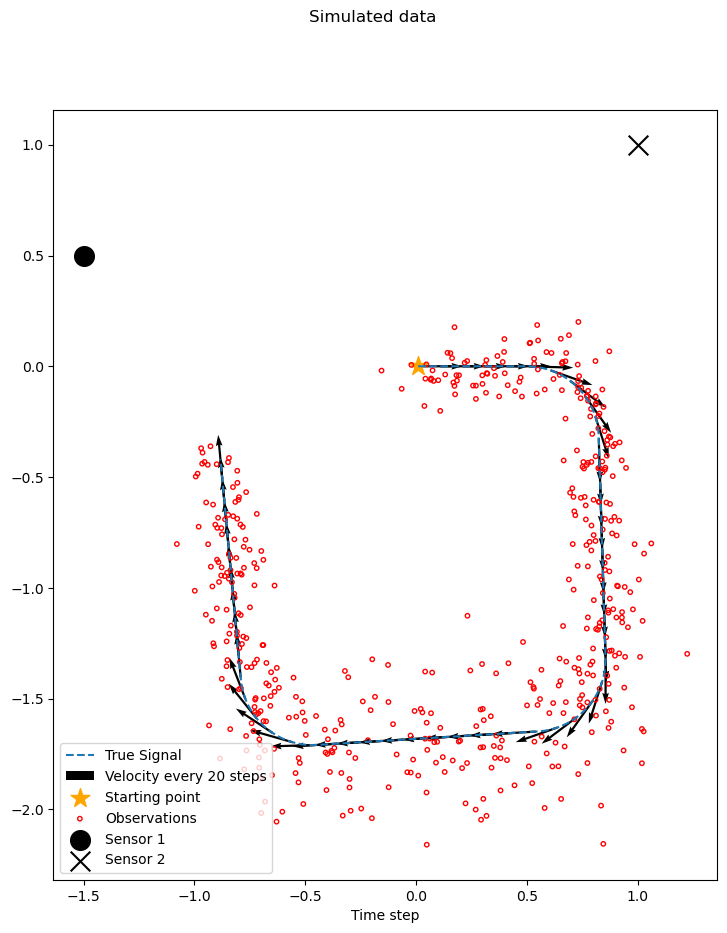

In [14]:
plot_bearings(true_states, thetas, sensors)

## Set up the model

- Transition matrix:

In [15]:
A = np.array([[1, 0, dt, 0], 
              [0, 1, 0, dt], 
              [0, 0, 1, 0], 
              [0, 0, 0, 1]])

- Parameter for the process noise covariance matrix

In [16]:
q = 0.1

- Process noise covariance matrix

In [17]:
Q = q * np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0], 
                  [0, dt ** 2 / 2, 0, dt ** 3 / 3], 
                  [dt ** 2 / 2, 0, dt, 0],
                  [0, dt ** 2 / 2, 0, dt]])


- Observation error covariance matrix

In [18]:
R = r ** 2 * np.eye(2)

## Initial Guess

We initialize to the true value with some uncertainty:

In [19]:
initial_state = true_states[0]
initial_covariance = np.eye(4)

In [20]:
def plot_results(true_states, approx_states, name, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    
    ax.plot(*true_states[:, :2].T, linestyle='--', label="True Signal")
    ax.plot(*approx_states[:, :2].T, linestyle='--', label=name)
    ax.scatter(*true_states[0, :2], marker="*", s=200, label="Starting point", color='orange')
    
    ax.set_xlabel("Time step")
    ax.legend(loc="upper left")
    fig.suptitle(title, y=0.95, fontsize=15)

## Baseline solution

We provide a baseline solution where the state is simply the inverse of the bearing measurement.

In [21]:
def baseline_update_method(x, cov, theta):
    """ A baseline method that inverts the bearings measurement: 
    we use a local function similar to inverse_bearings defined above.
    Example:
    >>> x = np.array([0.15, 0., 1., 1.])
    >>> cov = np.eye(4)
    >>> theta = np.array([np.atan(1), -np.atan(1)])
    >>> sensors = np.array([[-1., 0.], 
    ...                     [1., 0.]])
    >>> new_x, new_cov = baseline_update_method(x, cov, theta)
    >>> np.allclose(new_x, [0., -1., 0., 0.])
    True
    """
    tan_theta = np.tan(theta)
    ones =  np.ones_like(theta)
    matrices = np.stack([tan_theta, -ones], axis=-1)
    target_vectors = np.einsum("jk,jk->j", matrices, sensors)
    res = np.linalg.solve(matrices, target_vectors)
    return np.concatenate([res, np.zeros_like(res)]), cov


In [22]:
baseline_states, _ = filter_routine(initial_state, initial_covariance, baseline_update_method, thetas)

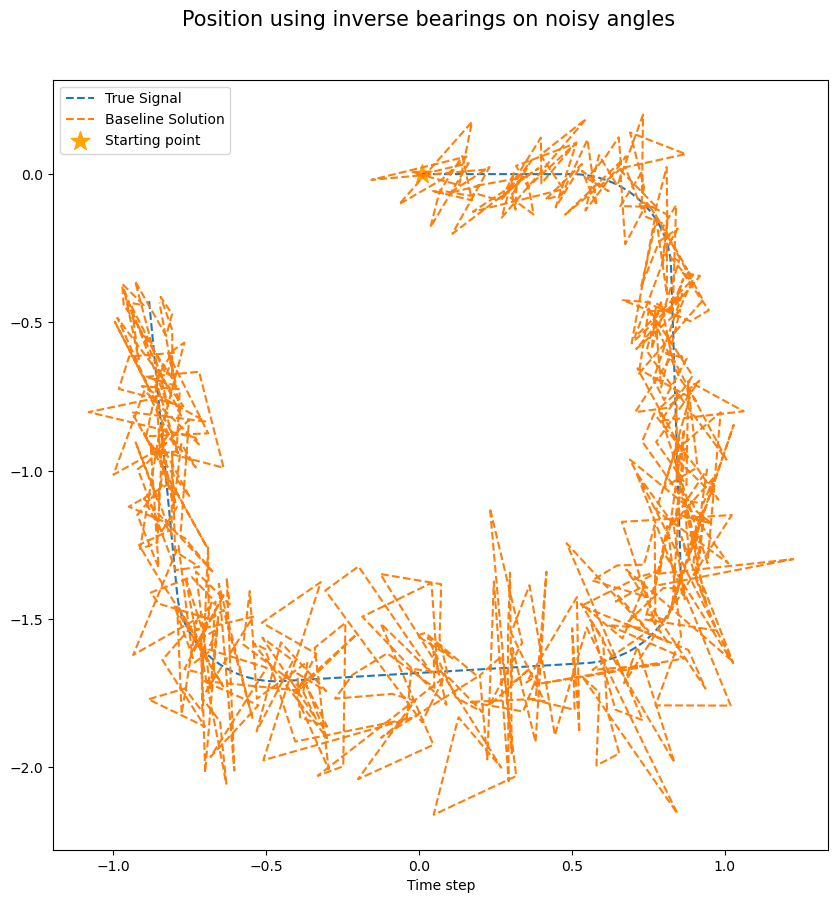

In [23]:
plot_results(true_states, baseline_states, "Baseline Solution", "Position using inverse bearings on noisy angles")

## Cubature Kalman Filter

In [24]:
def meas_fun(x):
    """
    The measurement model function.
    """
    angles = np.empty(2)
    for i in range(2):
        angles[i] = np.arctan2(x[1] - sensors[i][1], x[0] - sensors[i][0])
        
    return angles
        
def jac_meas_fun(x):
    """
    The Jacobian of the measurement model function.
    """
    eps = 1e-8 # To ensure there's no division by 0
    jacobian = np.zeros((2, len(x)))
    
    # Compute the arguments of arctan
    arg = np.empty(2)
    for i in range(2):
        arg[i] = (x[1] - sensors[i][1])/(x[0] - sensors[i][0] + eps)
    
    # Compute the non-zero terms of the Jacobian matrix
    for row in range(2):
        jacobian[row][0] = -1 * (x[1] - sensors[row][1]) / (x[0] - sensors[row][0] + eps)**2 / (1 + arg[row]**2 + eps)
        jacobian[row][1] = 1 / ((x[0] - sensors[row][0] + eps) * (1 + arg[row]**2))
        
    return jacobian

In [25]:
def cubature_kalman_filter(m_0, P_0, Q, dt, R, observations):
    # Compute the weights
    n = m_0.shape[-1]
    unit_sigma_points = np.concatenate([np.eye(n), -np.eye(n)]).T * np.sqrt(n)
    weights = np.full(2 * n, 0.5 / n)

    # Initial parameters
    steps = observations.shape[0]
    
    ckf_m = np.empty((steps, n))
    ckf_P = np.empty((steps, n, n))
    
    m = m_0[:]
    P = P_0[:]
    
    # Filtering loop
    for i in range(steps):
        y = observations[i]
        
        # Compute the sigma points for the dynamics
        L = np.linalg.cholesky(P)
        sigma_points = L @ unit_sigma_points + m.reshape(-1, 1)
        
        # Progagate through the dynamics
        sigma_points = A @ sigma_points 
        
        # Predicted state distribution
        m = np.dot(sigma_points, weights)
        P = np.dot(weights.reshape(1, -1) * (sigma_points - m.reshape(-1, 1)), (sigma_points - m.reshape(-1, 1)).T) + Q

        # Compute the sigma points for the observation
        L = np.linalg.cholesky(P)
        sigma_points = L @ unit_sigma_points + m.reshape(-1, 1)
        
        # Progagate through the measurement model
        sigma_observations = np.array([meas_fun(sp) for sp in sigma_points.T]).T  # Apply meas_fun to each sigma point
        
        # sigma points measurement mean and covariance
        predicted_mu = np.dot(sigma_observations, weights)
        
        predicted_cov = np.zeros((sigma_observations.shape[0], sigma_observations.shape[0]))  # Initialize covariance matrix
        for j in range(2 * n):
            # Outer product of the deviation from the predicted mean, weighted by `weights[j]`
            predicted_cov += weights[j] * np.outer(sigma_observations[:, j] - predicted_mu, sigma_observations[:, j] - predicted_mu)
        predicted_cov += R  # Add measurement noise covariance
        
        cross_cov = np.dot(sigma_points - m.reshape(-1, 1), weights.reshape(-1,1) * (sigma_observations.T - predicted_mu))
        
        # Gain and updated mean and covariance
        K = np.dot(cross_cov, np.linalg.inv(predicted_cov))  # Kalman gain
        m = m + K @ (y - predicted_mu) # Optimized for the scalar case as well as the following
        P = P - K @ predicted_cov @ K.T
        
        ckf_m[i] = m
        ckf_P[i] = P
    return ckf_m, ckf_P

In [26]:
ckf_states, ckf_covariances = cubature_kalman_filter(initial_state, initial_covariance, Q, dt, R, thetas)

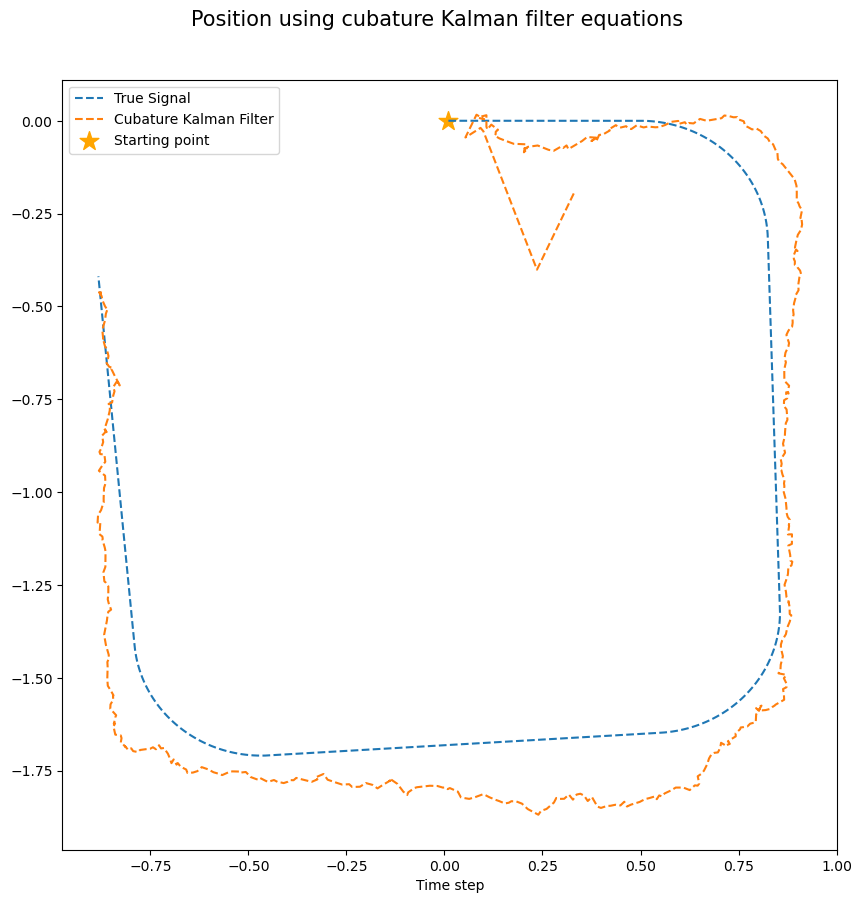

In [27]:
plot_results(true_states, ckf_states, "Cubature Kalman Filter", "Position using cubature Kalman filter equations")

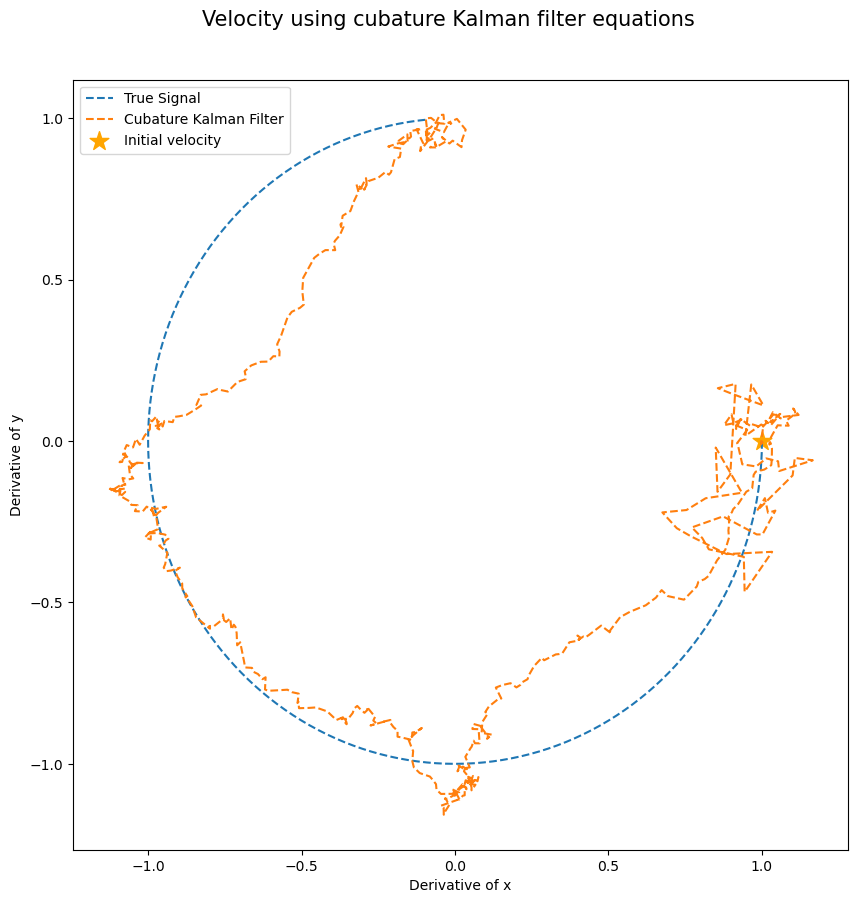

In [28]:
def plot_velocities(true_states, approx_states, name, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    
    ax.plot(*true_states[:, 2:].T, linestyle='--', label="True Signal")
    ax.plot(*approx_states[:, 2:].T, linestyle='--', label=name)
    ax.scatter(*true_states[0, 2:], marker="*", s=200, label="Initial velocity", color='orange')
    
    ax.set_xlabel("Derivative of x")
    ax.set_ylabel("Derivative of y")
    ax.legend(loc="upper left")
    fig.suptitle(title, y=0.95, fontsize=15)
    
plot_velocities(true_states, ckf_states, "Cubature Kalman Filter", "Velocity using cubature Kalman filter equations")

In [29]:
print(f"RMSE of the baseline solution is {rmse(true_states, baseline_states)}.")
print(f"RMSE of the CKF solution is {rmse(true_states, ckf_states)}.")

RMSE of the baseline solution is 0.5090760491035226.
RMSE of the CKF solution is 0.2703529531104404.


## Unscented Kalman Filter

In [30]:
def ukf_weights(alpha, beta, lamda, n):
    wm = np.full(2 * n + 1, 1 / (2 * (n + lamda)))
    wc = wm[:]
    
    wm[0] = lamda / (n + lamda)
    wc[0] = lamda / (n + lamda) + (1 - alpha ** 2 + beta)
    return wm, wc

In [31]:
def unscented_kalman_filter(m_0, P_0, Q, dt, R, observations):
    n = m_0.shape[-1]

    # UKF parameters (refer to the book for their meaning)
    alpha = 1
    beta = 0
    kappa = 3 - n
    lamda = alpha ** 2 * (n + kappa) - n  # lambda is a protected word in python
    wm, wc = ukf_weights(alpha, beta, lamda, n) 

    # Initialize
    steps = observations.shape[0]
    
    ukf_m = np.empty((steps, n))
    ukf_P = np.empty((steps, n, n))
    
    m = m_0[:]
    P = P_0[:]
    
    zeros = np.zeros((n, 1))
    
    for i in range(steps):
        y = observations[i]
        
        # Compute the sigma points for the dynamics
        L = np.linalg.cholesky(P) * np.sqrt(n + lamda)
        sigma_points = np.concatenate([zeros, L, -L], axis=1) + m.reshape(-1, 1)
        
        # Progagate through the dynamics
        sigma_points = A @ sigma_points      
        
        # Predicted state distribution
        m = np.dot(sigma_points, wm)
        P = np.dot(wc.reshape(1, -1) * (sigma_points - m.reshape(-1, 1)), (sigma_points - m.reshape(-1, 1)).T) + Q

        # Compute the sigma points for the observation
        L = np.linalg.cholesky(P) * np.sqrt(n + lamda)
        sigma_points = np.concatenate([zeros, L, -L], axis=1) + m.reshape(-1, 1)
        
        # Progagate through the measurement model
        sigma_observations = np.array([meas_fun(sp) for sp in sigma_points.T]).T
        
        # sigma points measurement mean and covariance
        predicted_mu = np.dot(sigma_observations, wm)
        
        predicted_cov = np.zeros((sigma_observations.shape[0], sigma_observations.shape[0]))  # Initialize covariance matrix
        for j in range(2 * n):
            # Outer product of the deviation from the predicted mean, weighted by `weights[j]`
            predicted_cov += wc[j] * np.outer(sigma_observations[:, j] - predicted_mu, sigma_observations[:, j] - predicted_mu)
        predicted_cov += R  # Add measurement noise covariance
        
        cross_cov = cross_cov = np.dot(sigma_points - m.reshape(-1, 1), wc.reshape(-1,1) * (sigma_observations.T - predicted_mu))
        
        # Gain
        K = np.dot(cross_cov, np.linalg.inv(predicted_cov))  # Kalman gain
        m = m + K @ (y - predicted_mu)
        P = P - K @ predicted_cov @ K.T
        
        ukf_m[i] = m
        ukf_P[i] = P
    return ukf_m, ukf_P

In [32]:
ukf_states, ukf_covariances = unscented_kalman_filter(initial_state, initial_covariance, Q, dt, R, thetas)

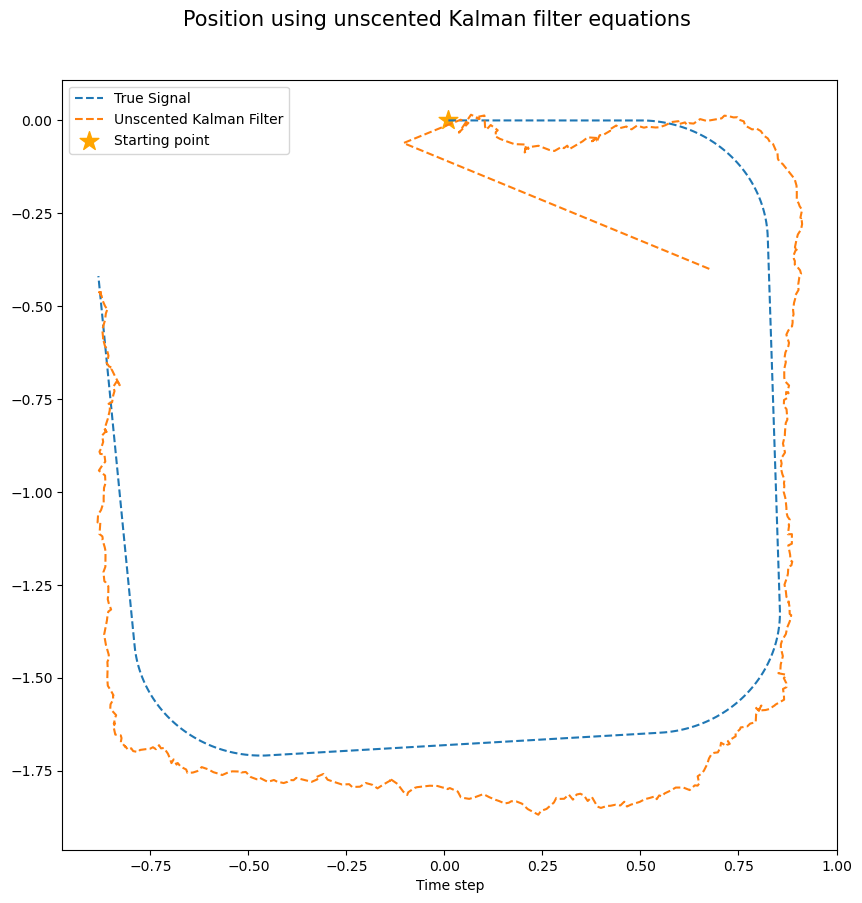

In [33]:
plot_results(true_states, ukf_states, "Unscented Kalman Filter", "Position using unscented Kalman filter equations")

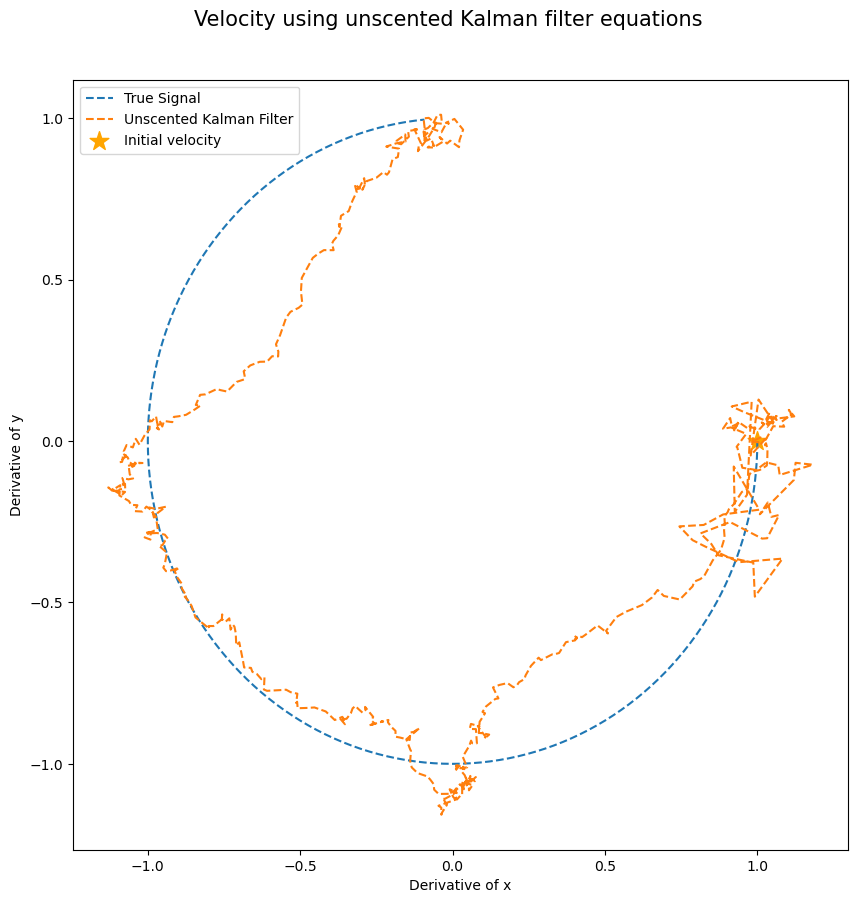

In [34]:
def plot_velocities(true_states, approx_states, name, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    
    ax.plot(*true_states[:, 2:].T, linestyle='--', label="True Signal")
    ax.plot(*approx_states[:, 2:].T, linestyle='--', label=name)
    ax.scatter(*true_states[0, 2:], marker="*", s=200, label="Initial velocity", color='orange')
    
    ax.set_xlabel("Derivative of x")
    ax.set_ylabel("Derivative of y")
    ax.legend(loc="upper left")
    fig.suptitle(title, y=0.95, fontsize=15)
    
plot_velocities(true_states, ukf_states, "Unscented Kalman Filter", "Velocity using unscented Kalman filter equations")

In [35]:
print(f"RMSE of the baseline solution is {rmse(true_states, baseline_states)}.")
print(f"RMSE of the UKF solution is {rmse(true_states, ukf_states)}.")

RMSE of the baseline solution is 0.5090760491035226.
RMSE of the UKF solution is 0.2704820205715691.
